In [1]:
#import libraries
import numpy as np
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle

In [2]:
path = "/kaggle/input/120-dog-breeds-breed-classification/Images"

In [3]:
#parameters
IMAGE_SIZE = [224, 224]
channel = 3
W, H = 224,224
num_class = 120
batch_size = 32

# Basic Function

In [4]:
#get directory of images
def get_labels(path):
  files = os.listdir(path)
  return files

In [5]:
#split the name and unique address
def get_splited_name(labels):
  splited_list = []
  labels_list = []
  for i in labels:
    splited = i.split('-')
    labels_list.append(splited[-1])
    splited_list.append(splited)
  
  return splited_list, labels_list

In [6]:
#create dictionary for name and unique address
def get_name_index(splited_list):
  new_list = [{item[0]: item[1]} for item in splited_list]
  return new_list

In [7]:
folder = get_labels(path)
splited_list, labels_list = get_splited_name(folder)
index_list = get_name_index(splited_list)

In [8]:
labels_list

['otterhound',
 'cocker_spaniel',
 'Brittany_spaniel',
 'Afghan_hound',
 'Maltese_dog',
 'schipperke',
 'Irish_setter',
 'Pekinese',
 'golden_retriever',
 'vizsla',
 'Welsh_springer_spaniel',
 'Staffordshire_bullterrier',
 'Border_collie',
 'Irish_terrier',
 'Eskimo_dog',
 'pug',
 'kelpie',
 'Yorkshire_terrier',
 'Tibetan_terrier',
 'Walker_hound',
 'affenpinscher',
 'Cardigan',
 'English_springer',
 'English_foxhound',
 'West_Highland_white_terrier',
 'Lakeland_terrier',
 'Rhodesian_ridgeback',
 'Gordon_setter',
 'Lhasa',
 'coated_retriever',
 'beagle',
 'Tibetan_mastiff',
 'Sussex_spaniel',
 'Saint_Bernard',
 'toy_terrier',
 'standard_poodle',
 'Bernese_mountain_dog',
 'Pomeranian',
 'Ibizan_hound',
 'redbone',
 'toy_poodle',
 'basset',
 'Scottish_deerhound',
 'miniature_pinscher',
 'basenji',
 'Border_terrier',
 'Bedlington_terrier',
 'Kerry_blue_terrier',
 'Weimaraner',
 'English_setter',
 'bluetick',
 'Boston_bull',
 'Italian_greyhound',
 'Dandie_Dinmont',
 'Airedale',
 'Irish_wat

In [9]:
index_list

[{'n02091635': 'otterhound'},
 {'n02102318': 'cocker_spaniel'},
 {'n02101388': 'Brittany_spaniel'},
 {'n02088094': 'Afghan_hound'},
 {'n02085936': 'Maltese_dog'},
 {'n02104365': 'schipperke'},
 {'n02100877': 'Irish_setter'},
 {'n02086079': 'Pekinese'},
 {'n02099601': 'golden_retriever'},
 {'n02100583': 'vizsla'},
 {'n02102177': 'Welsh_springer_spaniel'},
 {'n02093256': 'Staffordshire_bullterrier'},
 {'n02106166': 'Border_collie'},
 {'n02093991': 'Irish_terrier'},
 {'n02109961': 'Eskimo_dog'},
 {'n02110958': 'pug'},
 {'n02105412': 'kelpie'},
 {'n02094433': 'Yorkshire_terrier'},
 {'n02097474': 'Tibetan_terrier'},
 {'n02089867': 'Walker_hound'},
 {'n02110627': 'affenpinscher'},
 {'n02113186': 'Cardigan'},
 {'n02102040': 'English_springer'},
 {'n02089973': 'English_foxhound'},
 {'n02098286': 'West_Highland_white_terrier'},
 {'n02095570': 'Lakeland_terrier'},
 {'n02087394': 'Rhodesian_ridgeback'},
 {'n02101006': 'Gordon_setter'},
 {'n02098413': 'Lhasa'},
 {'n02099429': 'curly'},
 {'n0208836

In [10]:
num_classes = len(index_list)

In [11]:
num_classes

120

# Data Pipeline

In [12]:
def load_data(path, split=0.3):
  images = shuffle(glob(os.path.join(path,"*","*.jpg")))
  split_size = int(len(images)*split)
  #split data
  train_data, test_data = train_test_split(images, test_size=split_size, random_state=42)
  #train_data, test_data = train_test_split(train_data, test_size=split_size, random_state=42)

  return train_data, test_data

In [13]:
train_data, test_data = load_data(path)

In [14]:
print(f'train data: {len(train_data)}')
print(f'test data: {len(test_data)}')

train data: 14406
test data: 6174


In [15]:
train_data[0]

'/kaggle/input/120-dog-breeds-breed-classification/Images/n02093754-Border_terrier/n02093754_1861.jpg'

In [16]:
def process_image(path):
    #decode the path
    path = path.decode()
    #read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #resize the image
    image = cv2.resize(image, [W, H])
    #scale the image
    image = image / 255.0
    #change the data type of image
    image = image.astype(np.float32)

    #labeling the image
    class_name = path.split("/")[-2].split('-')[-1]
    class_idx = labels_list.index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return image, class_idx

In [17]:
def parse(path):
    image, labels = tf.numpy_function(process_image, [path], (tf.float32, tf.int32))
    labels = tf.one_hot(labels, num_class)
    image.set_shape([224, 224, 3])
    labels.set_shape(num_class)
  
    return image, labels

In [18]:
#tensorflow dataset
def tf_dataset(images, batch=64):
    dataset = tf.data.Dataset.from_tensor_slices((images))
    dataset = dataset.map(parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(64)
    return dataset

# Model 1 - VGG16

In [19]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [20]:
#freeze training existing layer
for layer in vgg.layers:
  layer.trainable = False

In [21]:
#build our layers
x = Flatten()(vgg.output)

In [22]:
#set last layer
prediction_layer = Dense(num_classes, activation='softmax' )(x)
#declare the model
model_I = Model(inputs=vgg.input, outputs=prediction_layer)

In [23]:
model_I.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Model II - Inception V3

In [24]:
inception = InceptionV3( include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + [3],
    classes=num_classes,
    classifier_activation='softmax'
)

87910968/87910968 [==============================] - 1s 0us/step


In [25]:
#freeze training existing layer
for layer in inception.layers:
  layer.trainable = False

In [26]:
#build our layers
x = Flatten()(inception.output)
x = Dropout(0.5)(x)

In [27]:
#set last layer
prediction_layer = Dense(num_classes, activation='softmax' )(x)
#declare the model
model_II = Model(inputs=inception.input, outputs=prediction_layer)

In [28]:
model_path = "/kaggle/working/dog-breed-inceptionV3.h5"
csv_path = "/kaggle/working/dog-breed.csv"

In [29]:
#initalize callbacks
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8, verbose=1)
]

In [30]:
model_II.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
#tensor dataset
train_df = tf_dataset(train_data)
test_df = tf_dataset(test_data)

In [32]:
#training
'''model_I.fit(
    train_df,
    validation_data=test_df,
    epochs=50,
    batch_size=32,
    steps_per_epoch=len(train_df),
    validation_steps=len(test_df),
    callbacks=callbacks
)'''

'model_I.fit(\n    train_df,\n    validation_data=test_df,\n    epochs=50,\n    batch_size=32,\n    steps_per_epoch=len(train_df),\n    validation_steps=len(test_df),\n    callbacks=callbacks\n)'

In [33]:
#training
model_II.fit(
    train_df,
    validation_data=test_df,
    steps_per_epoch=len(train_df),
    validation_steps=len(test_df),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/20
451/451 [==============================] - ETA: 0s - loss: 13.0157 - accuracy: 0.4958
Epoch 1: val_loss improved from inf to 11.95609, saving model to /kaggle/working/dog-breed-inceptionV3.h5
451/451 [==============================] - 181s 378ms/step - loss: 13.0157 - accuracy: 0.4958 - val_loss: 11.9561 - val_accuracy: 0.5977 - lr: 0.0010
Epoch 2/20
450/451 [============================>.] - ETA: 0s - loss: 5.6904 - accuracy: 0.7337
Epoch 2: val_loss did not improve from 11.95609
451/451 [==============================] - 92s 205ms/step - loss: 5.6882 - accuracy: 0.7337 - val_loss: 13.4840 - val_accuracy: 0.6058 - lr: 0.0010
Epoch 3/20
450/451 [============================>.] - ETA: 0s - loss: 3.4890 - accuracy: 0.8236
Epoch 3: val_loss did not improve from 11.95609
451/451 [==============================] - 92s 204ms/step - loss: 3.4875 - accuracy: 0.8237 - val_loss: 17.2010 - val_accuracy: 0.5933 - lr: 0.0010
Epoch 4/20
450/451 [============================>.] - ETA: 0s -

# Evaluate the model

In [34]:
model_II.evaluate(test_df)

193/193 [==============================] - 29s 149ms/step - loss: 13.4903 - accuracy: 0.6767


[13.49027156829834, 0.6767087578773499]

In [35]:
#function for get labels of test set
def get_test_data_class(test_path):
  names = []
  for i in test_path:
    name = i.split("/")[-2].split('-')[-1]
    name_idx = labels_list.index(name)
    names.append(name_idx)
  names = np.array(names, dtype=np.int32)
  return names

In [36]:
classes = get_test_data_class(test_data)

# test the model

In [37]:
#image and name
test_data[0]

'/kaggle/input/120-dog-breeds-breed-classification/Images/n02110806-basenji/n02110806_4156.jpg'

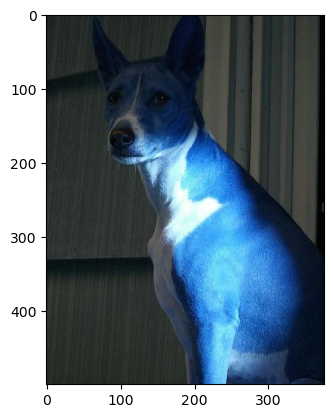

In [38]:
#read the image 
img = cv2.imread(test_data[0], cv2.IMREAD_COLOR)
plt.imshow(img)

In [39]:
img_new = cv2.resize(img, (224,224))
img = np.array(img_new).reshape(-1, 224, 224, 3)

In [40]:
img = img.astype('float32')
img /= 255

In [41]:
pred = model_II.predict(img, verbose=0)
pred

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 4.0013398e-26, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

In [42]:
val = np.argmax(pred)
val

44

In [43]:
name = int(val)
labels_list[name]

'basenji'